# Import Necessary Functions

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.spatial
import math
from math import sqrt
import matplotlib.pyplot as plt
import scipy.sparse as sps
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load MovieLens Dataset

In [2]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2022-11-27 07:34:39--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  23.2MB/s    in 0.2s    

2022-11-27 07:34:39 (23.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
header = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=header)
df.head() 

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Finding the Mean User Rating and Mean Movie Rating for Normalization

In [4]:
Mean_user_rating = df.groupby(by="userId",as_index=False)['rating'].mean()
Mean_user_rating

,userId,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


In [5]:
Mean_movie_rating = df.groupby(by="movieId",as_index=False)['rating'].mean()
Mean_movie_rating

,movieId,rating
0,1,3.878319
1,2,3.206107
2,3,3.033333
3,4,3.550239
4,5,3.302326
...,...,...
1677,1678,1.000000
1678,1679,3.000000
1679,1680,2.000000
1680,1681,3.000000


In [6]:
Mean_user_rating._get_value(0,'rating')

3.610294117647059

In [7]:
Mean_movie_rating._get_value(0,'rating')

3.8783185840707963

## Exploring the Data

In [8]:
# In[2]:
# get number of users and movies
n_users = df.userId.unique().shape[0]
n_movies = df.movieId.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_movies) + ' movies')

943 users
1682 movies


In [9]:
# In[3]:
import plotly.express as px
fig = px.histogram(df, x="rating")
fig.update_layout(
 title_text= 'Rating distribution in the dataset',
 title_xanchor= 'center',
 title_x = 0.5,
 title_xref='paper',
 xaxis_title='Rating',
  yaxis_title='Count'
)
fig.show()

In [10]:
# In[4]:
# create user movie matrix
user_movie_matrix = np.zeros((n_users, n_movies))


In [11]:
user_movie_matrix.shape

(943, 1682)

In [12]:
#Fill the user_movie_matrix with ratings row by row (user by user).
for line in df.itertuples():
 user_movie_matrix[line[1] - 1, line[2] - 1] = line[3]
user_movie_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [13]:
# In[5]:
# Calculate fill rate in the matrix
# fill rate = (number of ratings ∗ 100%) / (number of users ∗ number of items)
sparsity = float(len(user_movie_matrix.nonzero()[0])) /(user_movie_matrix.shape[0] * user_movie_matrix.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))
# So sparsity is found to be 6.3%. It means only 6.3% of all entries in the rating matrix are filled.
#


Sparsity: 6.30%


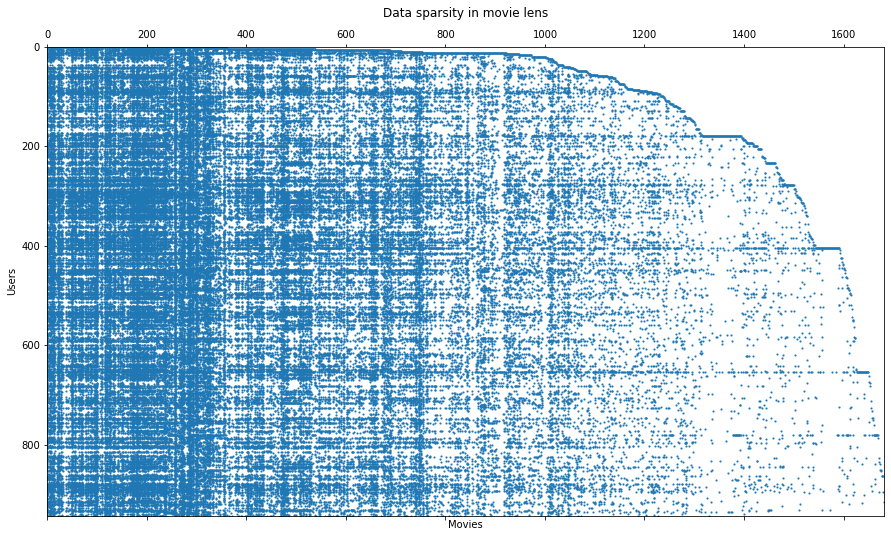

In [14]:
# In order to get a better picture of the rating information, the sparsity pattern
# of the data is illustrated.
# 
# In[6]:
plt.figure(figsize=(15,10))
plt.spy(sps.csr_matrix(user_movie_matrix), precision=0.001, markersize=
1, origin="lower")
plt.title('Data sparsity in movie lens')
plt.ylabel('Users')
plt.xlabel('Movies')
plt.show()
# All colored dots in the above plot represents known rating values and white areas represents unknown rating information.
#

In [15]:
# In[7]:
cosine_user_item_matrix =user_movie_matrix.copy()
# Pre-compute the user-user similarity matrix
for i in range(len(cosine_user_item_matrix)): #length of rows
   for j in range(len(cosine_user_item_matrix[i])): #length of columns
        cosine_user_item_matrix[i][j]=cosine_user_item_matrix[i][j] - Mean_user_rating._get_value(i,'rating') #row wise mean, ie, mean rating of a user is subtracted from the ratings of that user to account for bias
print(cosine_user_item_matrix)


[[ 1.38970588 -0.61029412  0.38970588 ... -3.61029412 -3.61029412
  -3.61029412]
 [ 0.29032258 -3.70967742 -3.70967742 ... -3.70967742 -3.70967742
  -3.70967742]
 [-2.7962963  -2.7962963  -2.7962963  ... -2.7962963  -2.7962963
  -2.7962963 ]
 ...
 [ 0.95454545 -4.04545455 -4.04545455 ... -4.04545455 -4.04545455
  -4.04545455]
 [-4.26582278 -4.26582278 -4.26582278 ... -4.26582278 -4.26582278
  -4.26582278]
 [-3.41071429  1.58928571 -3.41071429 ... -3.41071429 -3.41071429
  -3.41071429]]


In [16]:
cosine_user_item_matrix.shape

(943, 1682)

In [17]:
# In[8]:
# Cosine similarity calculation function
def cosine(first_matrix,second_matrix):
 return (first_matrix@second_matrix) / (((first_matrix@first_matrix)**.5) * ((second_matrix@second_matrix)**.5))

In [18]:
cosine_user_item_matrix[0].shape

(1682,)

# Cosine Similarity Matrix Computation

Cosine Similarity (denoted by w(u,v) for user-based collaborative filtering): $$ cos(\theta) =  \frac{\sum_{i=1}^{n}U_{i}.V_{i}}{\sqrt{\sum_{i=1}^{n}U_{i}^2}\sqrt{\sum_{i=1}^{n}V_{i}^2}}$$
where $U_{i}$ is the rating vector of user U and $V_{i}$ is the rating vector of user V.

In [19]:
# In[9]:
cosine_user_similarity = np.zeros((n_users,n_users))
for first_user in range(n_users):
 for second_user in range(n_users):
   #compute similarity only for lower triangular part first
  if first_user <= second_user:
    break
  try:
    cosine_user_similarity[first_user][second_user] = cosine(cosine_user_item_matrix[first_user],cosine_user_item_matrix[second_user])
  except: 
    cosine_user_similarity[first_user][second_user] = 0

# complete all entries by add the transposed similarity matrix to our previously computed values
cosine_user_similarity = cosine_user_similarity + cosine_user_similarity.T
print(cosine_user_similarity)

[[0.         0.89587283 0.88623883 ... 0.90452138 0.89299947 0.89849363]
 [0.89587283 0.         0.96435776 ... 0.97660006 0.96200095 0.92647207]
 [0.88623883 0.96435776 0.         ... 0.97597797 0.96111396 0.92205533]
 ...
 [0.90452138 0.97660006 0.97597797 ... 0.         0.97083589 0.93779748]
 [0.89299947 0.96200095 0.96111396 ... 0.97083589 0.         0.92806136]
 [0.89849363 0.92647207 0.92205533 ... 0.93779748 0.92806136 0.        ]]


In [20]:
# In[10]:
# Pre-compute the item-item similarity matrix
cosine_item_item_matrix = user_movie_matrix.T.copy()
for i in range(len(cosine_item_item_matrix)):
  for j in range(len(cosine_item_item_matrix[i])):
      cosine_item_item_matrix[i][j]=cosine_item_item_matrix[i][j] - Mean_movie_rating._get_value(i,'rating')
print(cosine_item_item_matrix) 

[[ 1.12168142  0.12168142 -3.87831858 ...  1.12168142 -3.87831858
  -3.87831858]
 [-0.20610687 -3.20610687 -3.20610687 ... -3.20610687 -3.20610687
   1.79389313]
 [ 0.96666667 -3.03333333 -3.03333333 ... -3.03333333 -3.03333333
  -3.03333333]
 ...
 [-2.         -2.         -2.         ... -2.         -2.
  -2.        ]
 [-3.         -3.         -3.         ... -3.         -3.
  -3.        ]
 [-3.         -3.         -3.         ... -3.         -3.
  -3.        ]]


# Cosine Similarity Matrix Computation

Cosine Similarity (denoted by w(i,j) for item-based collaborative filtering): $$ cos(\theta) =  \frac{\sum_{i=1}^{n}A_{i}.B_{i}}{\sqrt{\sum_{i=1}^{n}A_{i}^2}\sqrt{\sum_{i=1}^{n}B_{i}^2}}$$
where $A_{i}$ is the rating vector of movie A and $B_{i}$ is the rating vector of movie B.

In [21]:
# In[11]:
cosine_item_similarity = np.zeros((n_movies, n_movies))
user_item = user_movie_matrix.T.copy()
# compute the similarities in the lower triangle part
for first_item in range(n_movies):
 for second_item in range(n_movies):
  if first_item <= second_item:
    break
  try:
    cosine_item_similarity[first_item][second_item] = cosine(user_item[first_item], user_item[second_item])
  except:
    cosine_item_similarity[first_item][second_item] = 0

# complete all entries by add the transposed similarity matrix to our
# previously computed values 

cosine_item_similarity = cosine_item_similarity + cosine_item_similarity.T
print(cosine_item_similarity)

[[0.         0.40238218 0.33024479 ... 0.         0.04718307 0.04718307]
 [0.40238218 0.         0.27306918 ... 0.         0.07829936 0.07829936]
 [0.33024479 0.27306918 0.         ... 0.         0.         0.09687505]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04718307 0.07829936 0.         ... 0.         0.         0.        ]
 [0.04718307 0.07829936 0.09687505 ... 0.         0.         0.        ]]


In [22]:
cosine_item_similarity.shape

(1682, 1682)

In [23]:
# In[12]:
# split the data set into training set and testing set
train_data, test_data = train_test_split(df, test_size=0.25)

In [24]:
train_data

,userId,movieId,rating,timestamp
72426,833,240,4,875035624
854,311,654,3,884365075
32226,236,692,4,890116670
74415,613,576,3,891227204
6773,318,934,4,884495382
...,...,...,...,...
83166,114,135,4,881260611
61558,588,384,1,890032013
16053,1,164,3,876893171
48332,182,596,5,885613152


In [25]:
test_data

,userId,movieId,rating,timestamp
20474,201,773,4,884112627
91216,787,313,5,888979547
82402,694,474,4,875727226
60837,753,215,5,891402272
57213,125,111,3,892838322
...,...,...,...,...
50105,119,252,3,874780832
51451,211,705,4,879459952
66308,527,185,5,879455680
46778,247,64,5,893097024


# Computation of Predicted Rating for a Movie based on User-User Similarity


$$ \hat{r_{u,i}} = \bar{r_{u}} + \frac{\sum_{v=1}^{n} {r_{v,i}}{w_{u,v}}}{\sum_{v = 1}^{n} {w_{u,v}}}$$


In [37]:
# In[13]:
# Rating predict function based on the the user-user similarity
def user_user_predict_rmse(train, test, user_similarity, n_users, n_movies, k):

  print("Compute User based Collaborative filtering RMSE", " for K = ", k)
  # take the train set of ratings from user-item matrix
  train_df = pd.DataFrame(train)
  test_df = pd.DataFrame(test)
  exact_rating = []
  predicted_rating = []

  train_matrix = np.zeros((n_users, n_movies))
  for row in train_df.itertuples():
      train_matrix[int(row[1]) - 1, int(row[2]) - 1] = row[3]

  for test_row in test_df.itertuples(): #users are in the 1st column of test_df, items in the second column of test_df and ratings in the 3rd column
      user = int(test_row[1])
      item = int(test_row[2])
      exact_rating.append(test_row[3])

      item_prediction = 0.0

      if np.count_nonzero(train_matrix[user-1]):
          sim_cos = user_similarity[user - 1]
          # sort the similarities in descending order, find the k users items which has the largest similarities
          sorted_index = np.argsort(-sim_cos)
          mean_user = Mean_user_rating._get_value(user-1,'rating')
          normal_cos = 0
          dot = 0
          for l in range(k):
              ind = sorted_index[l]
              # normalize the similarity for the rated items
              normal_cos += np.absolute(sim_cos[ind])
              # multiply the ratings with similarity scores and add them up
              dot += sim_cos[ind] * train_matrix[ind][item-1]
          if normal_cos > 0:
              item_prediction = mean_user + dot / normal_cos
 
      if item_prediction < 0:
          item_prediction = 0
      if item_prediction > 5:
          item_prediction = 5

      predicted_rating.append(item_prediction)

  rmse= sqrt(mean_squared_error(exact_rating, predicted_rating)) #Compute the mean squared error between the predicted rating and exact rating extracted from the test set.
  
  return rmse,predicted_rating

# Computation of Rating Prediction based on item-item Similarity 
$$ \hat{r_{u,i}} = \bar{r_{i}} + \frac{\sum_{j=1}^{n} {r_{u,j}}{w_{i,j}}}{\sum_{j = 1}^{n} {w_{i,j}}}$$

In [38]:

# In[14]:
#Rating predict function based on the the item-item similarity
def item_item_predict_rmse(train, test, item_similarity, n_users, n_movies, k):
    print("Compute Item based Collaborative Filtering RMSE", " for K = ", k)
    # transfer the train set of ratings to user-item matrix
    train_df = pd.DataFrame(train)
    test_df = pd.DataFrame(test)
    exact_rating = []
    predicted_rating = []

    train_matrix = np.zeros((n_users, n_movies))
    for row in train_df.itertuples():
        train_matrix[row[1] - 1, row[2] - 1] = row[3]

    for test_row in test_df.itertuples(): 
        user = test_row[1]
        item = test_row[2]
        exact_rating.append(test_row[3])

        item_prediction = 0.0

        if np.count_nonzero(train_matrix[:, item - 1]):
            sim_cos_item = item_similarity[item - 1] 
            mean_movie = Mean_movie_rating._get_value(item-1,'rating')
            # sort the similarities, find the k similar items which has the largest similarities
            sorted_index = np.argsort(-sim_cos_item)
            normal_cos_item = 0
            dot = 0
            for n in range(k):
                ind = sorted_index[n]
                # normalize the similarity for the rated items
                normal_cos_item += np.absolute(sim_cos_item[ind])
                # similarity multiply the ratings
                dot += sim_cos_item[ind] * train_matrix[user - 1][ind]
            if normal_cos_item > 0:
                item_prediction = mean_movie + dot / normal_cos_item

        if item_prediction < 0:
            item_prediction = 0
        if item_prediction > 5:
            item_prediction = 5
 
        predicted_rating.append(item_prediction)

    rmse= sqrt(mean_squared_error(exact_rating, predicted_rating))
    

    return rmse, predicted_rating

In [39]:
# In[15]:
cosine_rmse_user = []
cosine_rmse_item =[]

for i in range(3,10):
 k = i
 #user-based cosine CF
 rmse_user_cosine, pred_rate_user_cosine = user_user_predict_rmse(train_data, test_data, cosine_user_similarity, n_users, n_movies, k)
 cosine_rmse_user.append(rmse_user_cosine)
 #item-based cosine CF
 rmse_item_cosine, pred_rate_item_cosine = item_item_predict_rmse(train_data, test_data, cosine_item_similarity, n_users, n_movies, k)
 cosine_rmse_item.append(rmse_item_cosine)
for i in [1,2,3,4,5,6,7,8,9,10,20]:
   k = i * 10
  #user-based cosine CF
   rmse_user_cosine, pred_rate_user_cosine = user_user_predict_rmse(train_data, test_data, cosine_user_similarity, n_users, n_movies, k)
   cosine_rmse_user.append(rmse_user_cosine)
  #item-based cosine CF
   rmse_item_cosine, pred_rate_item_cosine = item_item_predict_rmse(train_data, test_data, cosine_item_similarity, n_users, n_movies, k)
   cosine_rmse_item.append(rmse_item_cosine)

Compute User based Collaborative filtering RMSE  for K =  3
Compute Item based Collaborative Filtering RMSE  for K =  3
Compute User based Collaborative filtering RMSE  for K =  4
Compute Item based Collaborative Filtering RMSE  for K =  4
Compute User based Collaborative filtering RMSE  for K =  5
Compute Item based Collaborative Filtering RMSE  for K =  5
Compute User based Collaborative filtering RMSE  for K =  6
Compute Item based Collaborative Filtering RMSE  for K =  6
Compute User based Collaborative filtering RMSE  for K =  7
Compute Item based Collaborative Filtering RMSE  for K =  7
Compute User based Collaborative filtering RMSE  for K =  8
Compute Item based Collaborative Filtering RMSE  for K =  8
Compute User based Collaborative filtering RMSE  for K =  9
Compute Item based Collaborative Filtering RMSE  for K =  9
Compute User based Collaborative filtering RMSE  for K =  10
Compute Item based Collaborative Filtering RMSE  for K =  10
Compute User based Collaborative filte

In [40]:
# In[16]:
print("User-based cosine RMSE: ", cosine_rmse_user)
print("Item-based cosine RMSE: ", cosine_rmse_item)

User-based cosine RMSE:  [1.2241756045906138, 1.2129575181282697, 1.204977738220448, 1.1982897947920135, 1.1923076491412785, 1.1886382000699687, 1.1854411993757141, 1.1822099004212363, 1.157609705232759, 1.1432056524523662, 1.134859283636499, 1.1280721292730145, 1.122416298957138, 1.1166858453769517, 1.1118665458617016, 1.1066963156812026, 1.1034183999334128, 1.0777910711813068]
Item-based cosine RMSE:  [1.500091074074763, 1.5062814086501213, 1.5112174373183205, 1.5138901795697692, 1.5177246472761632, 1.5213864493191411, 1.5237989181662621, 1.5235837560307994, 1.523318881552965, 1.5163846687448397, 1.5099569368542214, 1.5019838058173351, 1.4965159660829586, 1.4915935544004977, 1.4867394055801153, 1.4811340680236618, 1.4758342975336467, 1.4300743411851022]


In [41]:
# In[17]:
import plotly.graph_objects as go
x_label = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_label, y=cosine_rmse_user, mode='lines+markers', name='User CF based on cosine'))
fig.add_trace(go.Scatter(x=x_label, y=cosine_rmse_item,mode='lines+markers',name='Item CF based on cosine'))
fig.update_layout(
 title='Collaborative Filter Rating Prediction using Cosine Similarity Performance Benchmark',
 title_xanchor= 'center',
 title_x = 0.5,
 title_xref='paper',
 xaxis_title='Number of Neighbors (K)',
 yaxis_title='RMSE (Root Mean Square Error)',
 legend_orientation="h"
)
fig.show()


# Compuatation of Rating Prediction Using Pearson Correlation

## Pearson Correlation between Users



In [31]:
# In[18]:
pearson_user_similarity = np.zeros((n_users, n_users))
# compute the similarities in the upper triangle part
for user1 in range(n_users):
    for user2 in range(n_users):
      if user1 <= user2: 
          break
      elif np.count_nonzero(user_movie_matrix[user1]) and np.count_nonzero(user_movie_matrix[user2]):
          try:
              if not math.isnan(scipy.stats.pearsonr(user_movie_matrix[user1], user_movie_matrix[user2])[0]):
                  pearson_user_similarity[user1][user2] = scipy.stats.pearsonr(user_movie_matrix[user1], user_movie_matrix[user2])[0]
              else:
                  pearson_user_similarity[user1][user2] = 0
          except:
              pearson_user_similarity[user1][user2] = 0

# complete all entries by add the transposed similarity matrix to our
# previously computed values
pearson_user_similarity = pearson_user_similarity + pearson_user_similarity.T

print(pearson_user_similarity)

[[ 0.          0.10632193 -0.01642393 ...  0.1155035   0.10898367
   0.32323078]
 [ 0.10632193  0.          0.08268017 ...  0.14417664  0.13829245
   0.05423526]
 [-0.01642393  0.08268017  0.         ...  0.08453195  0.10202478
  -0.02360053]
 ...
 [ 0.1155035   0.14417664  0.08453195 ...  0.          0.08012962
   0.06529963]
 [ 0.10898367  0.13829245  0.10202478 ...  0.08012962  0.
   0.12773543]
 [ 0.32323078  0.05423526 -0.02360053 ...  0.06529963  0.12773543
   0.        ]]


## Pearson Correlation between Movies

In [32]:
# In[19]:
pearson_item_similarity = np.zeros((n_movies, n_movies))
data = user_movie_matrix.T.copy()
# compute the similarities in the upper triangle part
for item1 in range(n_movies):
    for item2 in range(n_movies):
        if item1 <= item2:
          break
        elif np.count_nonzero(data[item1]) and np.count_nonzero(data[item2]):
            try:
                if not math.isnan(scipy.stats.pearsonr(data[item1], data[item2])[0]):
                    pearson_item_similarity[item1][item2] = scipy.stats.pearsonr(data[item1], data[item2])[0]
                else:
                    pearson_item_similarity[item1][item2] = 0
            except:
                pearson_item_similarity[item1][item2] = 0

# complete all entries by add the transposed similarity matrix to our
# previously computed values 
pearson_item_similarity = pearson_item_similarity + pearson_item_similarity.T
print(pearson_item_similarity)

[[ 0.          0.23459453  0.19336208 ... -0.02967574  0.03417873
   0.03417873]
 [ 0.23459453  0.          0.1906486  ... -0.01245099  0.07141535
   0.07141535]
 [ 0.19336208  0.1906486   0.         ... -0.00976446 -0.00976446
   0.09142113]
 ...
 [-0.02967574 -0.01245099 -0.00976446 ...  0.         -0.00106157
  -0.00106157]
 [ 0.03417873  0.07141535 -0.00976446 ... -0.00106157  0.
  -0.00106157]
 [ 0.03417873  0.07141535  0.09142113 ... -0.00106157 -0.00106157
   0.        ]]


In [33]:
# In[20]:
pearson_rmse_user = []
pearson_rmse_item = []
for i in range(3,10):
 k = i
 # user-based pearson CF
 rmse_user, pred_rate_user = user_user_predict_rmse(train_data, test_data, pearson_user_similarity, n_users, n_movies, k)
 pearson_rmse_user.append(rmse_user)
 # item-based pearson CF
 rmse_item, pred_rate_item = item_item_predict_rmse(train_data, test_data, pearson_item_similarity, n_users, n_movies, k)
 pearson_rmse_item.append(rmse_item)
for i in range(1,11):
  k = i * 10
  # user-based pearson CF
  rmse_user, pred_rate_user = user_user_predict_rmse(train_data, test_data, pearson_user_similarity, n_users, n_movies, k)
  pearson_rmse_user.append(rmse_user)
  # item-based pearson CF
  rmse_item, pred_rate_item = item_item_predict_rmse(train_data, test_data, pearson_item_similarity, n_users, n_movies, k)
  pearson_rmse_item.append(rmse_item) 


Compute User based Collaborative filtering RMSE  for K =  3
Compute Item based Collaborative Filtering RMSE  for K =  3
Compute User based Collaborative filtering RMSE  for K =  4
Compute Item based Collaborative Filtering RMSE  for K =  4
Compute User based Collaborative filtering RMSE  for K =  5
Compute Item based Collaborative Filtering RMSE  for K =  5
Compute User based Collaborative filtering RMSE  for K =  6
Compute Item based Collaborative Filtering RMSE  for K =  6
Compute User based Collaborative filtering RMSE  for K =  7
Compute Item based Collaborative Filtering RMSE  for K =  7
Compute User based Collaborative filtering RMSE  for K =  8
Compute Item based Collaborative Filtering RMSE  for K =  8
Compute User based Collaborative filtering RMSE  for K =  9
Compute Item based Collaborative Filtering RMSE  for K =  9
Compute User based Collaborative filtering RMSE  for K =  10
Compute Item based Collaborative Filtering RMSE  for K =  10
Compute User based Collaborative filte

In [34]:
# In[21]:
print("User-based RMSE: ", pearson_rmse_user)
print("Item-based RMSE: ", pearson_rmse_item)

User-based RMSE:  [1.415029669027476, 1.4162459968093886, 1.4180590824123298, 1.4173868966526688, 1.414599766209248, 1.4156044225678661, 1.416227169314125, 1.4161556635441641, 1.4086317694082577, 1.3994926613794099, 1.3915968813737105, 1.3840643179985255, 1.3779439064820111, 1.3721174034777168, 1.3669762553522895, 1.361481873336714, 1.3560227925495796]
Item-based RMSE:  [1.4297360124744802, 1.4327207791098426, 1.4347429807828231, 1.4342780413516214, 1.4360926772204903, 1.4374731278976862, 1.4363303745711986, 1.436151913782466, 1.4291659754498556, 1.419816115440064, 1.411295659803323, 1.4039202132356818, 1.3970325054429533, 1.390188754131438, 1.3846865392129568, 1.3797311797693905, 1.3753859147779142]


In [35]:
# In[22]:
import plotly.graph_objects as go
x_label = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_label, y=pearson_rmse_user,mode='lines+markers', name='User CF based on Pearson'))
fig.add_trace(go.Scatter(x=x_label, y=pearson_rmse_item,mode='lines+markers',name='Item CF based on Pearson'))
fig.update_layout(
 title='Collaborative Filter Rating Prediction using Pearson Performance Benchmark',
 title_xanchor= 'center',
 title_x = 0.5,
 title_xref='paper',
 xaxis_title='Number of Neighbors (K)',
 yaxis_title='RMSE (Root Mean Square Error)',
 legend_orientation="h"
)
fig.show()

In [36]:
# In[23]:
import plotly.graph_objects as go
x_label = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_label, y=pearson_rmse_user,mode='lines+markers', name='User CF based on Pearson'))
fig.add_trace(go.Scatter(x=x_label, y=pearson_rmse_item,mode='lines+markers',name='Item CF based on Pearson'))
fig.add_trace(go.Scatter(x=x_label, y=cosine_rmse_user, mode='lines+markers', name='User CF based on cosine'))
fig.add_trace(go.Scatter(x=x_label, y=cosine_rmse_item,mode='lines+markers',name='Item CF based on cosine'))
fig.update_layout(title='Comparison of Collaborative Filter Rating Prediction Performance Benchmark',
 title_xanchor= 'center',
 title_x = 0.5,
 title_xref='paper',
 xaxis_title='Number of Neighbors (K)',
 yaxis_title='RMSE (Root Mean Square Error)',
 legend_orientation="h"
)
fig.show()

## Rough Work

In [ ]:
pa = pd.DataFrame({'num_legs': [4, 2, 4, 2], 'num_wings': [3, 2, 4, 2], 'num_eyes': [2,3,4,5], 'num_ears': [2,1,3,6]},
                  index=['dog', 'hawk', 'giraffe', 'sparrow'])

In [ ]:
pa

,num_legs,num_wings,num_eyes,num_ears
dog,4,3,2,2
hawk,2,2,3,1
giraffe,4,4,4,3
sparrow,2,2,5,6


In [ ]:
pa_matrix = np.zeros((4, 4))

In [ ]:
pa_matrix

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
for line in pa.itertuples():
 pa_matrix[line[1] - 1, line[2] - 1] = line[3]
print(pa_matrix)

[[0. 0. 0. 0.]
 [0. 5. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 4.]]


In [ ]:
user_movie_matrix[11,202]

3.0

In [ ]:
line[2]

203

In [ ]:
line

Pandas(Index=99999, userId=12, movieId=203, rating=3, timestamp=879959583)

In [ ]:
line[3]

3

In [ ]:
user_movie_matrix.nonzero()

(array([  0,   0,   0, ..., 942, 942, 942]),
 array([   0,    1,    2, ..., 1187, 1227, 1329]))

In [ ]:
cosine_user_item_matrix[i][np.where(cosine_user_item_matrix[i]!=0)]

array([ 5.        ,  3.        ,  4.        ,  5.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        3.        ,  4.        ,  5.        ,  4.        ,  1.        ,
        3.        ,  4.        ,  5.        ,  5.        ,  4.        ,
        3.        ,  5.        ,  4.        ,  4.        ,  5.        ,
        2.        ,  3.        ,  4.        ,  5.        ,  2.        ,
        5.        ,  4.        ,  4.        ,  2.        ,  5.        ,
        5.        ,  4.        ,  4.        ,  3.        ,  1.        ,
        3.        ,  5.        ,  3.        ,  1.        ,  4.        ,
        4.        ,  2.        ,  4.        ,  5.        ,  4.        ,
        4.        ,  5.        ,  5.        ,  2.        ,  5.        ,
        5.        ,  4.        ,  4.        ,  5.        ,  4.        ,
        5.        ,  4.        ,  5.        ,  2.        ,  3.        ,
        5.        ,  4.        ,  5.        ,  4.        ,  3.  

In [ ]:
cosine_user_item_matrix[1]

array([ 4.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -3.70967742])

In [ ]:
len(cosine_user_item_matrix)

943

In [ ]:
len(cosine_user_item_matrix[i])

1682

In [ ]:
cosine_user_item_matrix[i][np.where(cosine_user_item_matrix[i]!=0)].mean()

3.3703508030431113

In [ ]:
sim_cos1 = cosine_user_similarity[300]
sim_cos1

array([ 0.28578482,  0.05892403,  0.04705757,  0.06520901,  0.24249089,
        0.20643328,  0.31450671,  0.27584771,  0.08995058,  0.25391068,
        0.1750122 ,  0.18841847,  0.25569441,  0.16233143,  0.08132153,
        0.31591309,  0.07183928,  0.20997416,  0.06061208,  0.20842877,
        0.09179533,  0.36769763,  0.22220737,  0.16201205,  0.22200107,
        0.21583866,  0.09299177,  0.23602001,  0.04964374,  0.08565244,
        0.03072363,  0.12819501,  0.06685431, -0.01325396,  0.04043212,
        0.01148324,  0.25608116,  0.2177265 ,  0.04692857,  0.02838921,
        0.18271008,  0.39869631,  0.30398297,  0.32859666,  0.1285185 ,
        0.02969816,  0.03548283,  0.19633671,  0.07637379,  0.00423105,
        0.19846957,  0.14609538,  0.18935219,  0.16845396,  0.09270791,
        0.40829804,  0.32260894,  0.20687742,  0.33335354,  0.22590891,
        0.0457009 ,  0.31110916,  0.11975223,  0.38400916,  0.18220188,
        0.21597929,  0.09214081,  0.12331638,  0.18701965,  0.33

In [ ]:
sorted_index = np.argsort(-sim_cos1)
sorted_index[1]

803